In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import time
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [2]:
dhw_merge = pd.read_csv('dhw_merge.csv')
elec_merge  = pd.read_csv('elec_merge.csv')

dhw_merge = dhw_merge.drop(['YEAR'], axis=1)
elec_merge = elec_merge.drop(['YEAR'], axis=1)

##  For Scaling

In [3]:
dhw_X = dhw_merge.drop(['DHW'], axis=1)
dhw_Y = dhw_merge[['DHW']]

scaler_dhw = MinMaxScaler()
scaler_dhw.fit(dhw_X)
scaled_dhw_X = scaler_dhw.transform(dhw_X)

new_dhw_X = pd.DataFrame(scaled_dhw_X, index=dhw_X.index, columns=dhw_X.columns)
new_dhw = pd.concat([new_dhw_X, dhw_Y], axis=1)

In [4]:
elec_X = elec_merge.drop(['ELEC'], axis=1)
elec_Y = elec_merge[['ELEC']]

scaler_elec = MinMaxScaler()
scaler_elec.fit(elec_X)
scaled_elec_X = scaler_elec.transform(elec_X)

new_elec_X = pd.DataFrame(scaled_elec_X, index=elec_X.index, columns=elec_X.columns)
new_elec = pd.concat([new_elec_X, elec_Y], axis=1)

In [5]:
input_dhw = new_dhw.iloc[:-1,]
target_dhw = new_dhw[['DHW']].iloc[1:]

trainX_dhw, testX_dhw, trainY_dhw, testY_dhw = train_test_split(input_dhw,target_dhw,test_size=0.3,shuffle=False,random_state=0)

In [6]:
input_elec = new_elec.iloc[:-1,]
target_elec = new_elec[['ELEC']].iloc[1:]

trainX_elec, testX_elec, trainY_elec, testY_elec = train_test_split(input_elec,target_elec,test_size=0.3,shuffle=False,random_state=0)

In [7]:
def buildDataSet(input, target, seqLength):
    xdata = []
    ydata = []
    for i in range(len(input) - seqLength):
        tx = input.iloc[i:i+seqLength]
        ty = target.iloc[i+seqLength-1]
        xdata.append(tx)
        ydata.append(ty)
    return np.array(xdata), np.array(ydata)

In [8]:
trainx_dhw, trainy_dhw = buildDataSet(trainX_dhw, trainY_dhw, 24)
testx_dhw, testy_dhw = buildDataSet(testX_dhw, testY_dhw, 24)
trainx_elec, trainy_elec = buildDataSet(trainX_elec, trainY_elec, 24)
testx_elec, testy_elec = buildDataSet(testX_elec, testY_elec, 24)

In [22]:
class Seq2SeqModel(tf.keras.models.Model):
    def __init__(self):
        super(Seq2SeqModel, self).__init__()
        
        # for feature extracting
        self.conv1 = tf.keras.layers.Conv1D(64, 1)
        self.pool1 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        self.conv2 = tf.keras.layers.Conv1D(32, 1)
        self.pool2 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        self.conv3 = tf.keras.layers.Conv1D(128, 1)
        self.pool3 = tf.keras.layers.MaxPool1D(pool_size=2, strides=1, padding='same')
        
        # Encoder
        self.encoder1 = tf.keras.layers.LSTM(64, return_sequences=True, activation='tanh')
        self.encoder2 = tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh')
        self.encoder3 = tf.keras.layers.LSTM(128, return_sequences=True, return_state=True, activation='tanh')
        
        # Decoder
        self.decoder1 = tf.keras.layers.LSTM(128, return_sequences=True, activation='tanh')
        self.decoder2 = tf.keras.layers.LSTM(32, return_sequences=True, activation='tanh')
        self.decoder3 = tf.keras.layers.LSTM(64, return_sequences=True, activation='tanh')
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1)
        self.tanh = tf.keras.layers.Activation('tanh')
        self.swish = tf.keras.layers.Activation('swish')

    def call(self, x):
        x = self.conv1(x)
        x = self.swish(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.swish(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.swish(x)
        x = self.pool3(x)
        
        x = self.encoder1(x)
        x = self.encoder2(x)
        x, h, c = self.encoder3(x)
        
        x = self.decoder1(x, initial_state=[h, c])
        x = self.decoder2(x)
        x = self.decoder3(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.swish(x)
        return x

In [23]:
model = Seq2SeqModel()
model.build(input_shape=(1024, 24, 12))
model.summary()

Model: "seq2_seq_model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           multiple                  832       
                                                                 
 max_pooling1d_9 (MaxPooling  multiple                 0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          multiple                  2080      
                                                                 
 max_pooling1d_10 (MaxPoolin  multiple                 0         
 g1D)                                                            
                                                                 
 conv1d_11 (Conv1D)          multiple                  4224      
                                                                 
 max_pooling1d_11 (MaxPoolin  multiple            

In [25]:
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adamax(learning_rate=3e-4, clipnorm=1.0), metrics=['mae'])

# EarlyStopping과 ModelCheckpoint 콜백 정의
earlystopping = EarlyStopping(monitor='loss', patience=50)
checkpoint = ModelCheckpoint(filepath='0920_seq2seq_tensorflow', monitor='loss', save_best_only=True)

# 모델 학습
model.fit(trainx_elec, trainy_elec, epochs=1000, batch_size=1024, callbacks=[earlystopping, checkpoint])

# SavedModel 형식으로 모델 저장
model.save('0920_seq2seq_tensorflow_savedmodel')

Epoch 1/1000


3/3 [==============================] - ETA: 0s - loss: 0.5906 - mae: 0.5906WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 12s 4s/step - loss: 0.5906 - mae: 0.5906
Epoch 2/1000
3/3 [==============================] - ETA: 0s - loss: 0.5612 - mae: 0.5612WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 5s/step - loss: 0.5612 - mae: 0.5612
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 0.5167 - mae: 0.5167WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.5167 - mae: 0.5167
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 0.4498 - mae: 0.4498WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.4498 - mae: 0.4498
Epoch 5/1000
3/3 [==============================] - ETA: 0s - loss: 0.3605 - mae: 0.3605WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.3605 - mae: 0.3605
Epoch 6/1000
3/3 [==============================] - ETA: 0s - loss: 0.2923 - mae: 0.2923WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2923 - mae: 0.2923
Epoch 7/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.3332 - mae: 0.3332
Epoch 8/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.3070 - mae: 0.3070
Epoch 9/1000
3/3 [==============================] - ETA: 0s - loss: 0.2858 - mae: 0.2858WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 5s/step - loss: 0.2858 - mae: 0.2858
Epoch 10/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.2928 - mae: 0.2928
Epoch 11/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.2964 - mae: 0.2964
Epoch 12/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.2906 - mae: 0.2906
Epoch 13/1000
3/3 [==============================] - ETA: 0s - loss: 0.2825 - mae: 0.2825WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2825 - mae: 0.2825
Epoch 14/1000
3/3 [==============================] - ETA: 0s - loss: 0.2802 - mae: 0.2802WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 5s/step - loss: 0.2802 - mae: 0.2802
Epoch 15/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.2822 - mae: 0.2822
Epoch 16/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.2802 - mae: 0.2802
Epoch 17/1000
3/3 [==============================] - ETA: 0s - loss: 0.2768 - mae: 0.2768WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2768 - mae: 0.2768
Epoch 18/1000
3/3 [==============================] - ETA: 0s - loss: 0.2761 - mae: 0.2761WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2761 - mae: 0.2761
Epoch 19/1000
3/3 [==============================] - ETA: 0s - loss: 0.2754 - mae: 0.2754WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 5s/step - loss: 0.2754 - mae: 0.2754
Epoch 20/1000
3/3 [==============================] - ETA: 0s - loss: 0.2734 - mae: 0.2734WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2734 - mae: 0.2734
Epoch 21/1000
3/3 [==============================] - ETA: 0s - loss: 0.2711 - mae: 0.2711WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2711 - mae: 0.2711
Epoch 22/1000
3/3 [==============================] - ETA: 0s - loss: 0.2699 - mae: 0.2699WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 5s/step - loss: 0.2699 - mae: 0.2699
Epoch 23/1000
3/3 [==============================] - ETA: 0s - loss: 0.2680 - mae: 0.2680WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 5s/step - loss: 0.2680 - mae: 0.2680
Epoch 24/1000
3/3 [==============================] - ETA: 0s - loss: 0.2658 - mae: 0.2658WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2658 - mae: 0.2658
Epoch 25/1000
3/3 [==============================] - ETA: 0s - loss: 0.2638 - mae: 0.2638WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2638 - mae: 0.2638
Epoch 26/1000
3/3 [==============================] - ETA: 0s - loss: 0.2617 - mae: 0.2617WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2617 - mae: 0.2617
Epoch 27/1000
3/3 [==============================] - ETA: 0s - loss: 0.2591 - mae: 0.2591WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 5s/step - loss: 0.2591 - mae: 0.2591
Epoch 28/1000
3/3 [==============================] - ETA: 0s - loss: 0.2565 - mae: 0.2565WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 5s/step - loss: 0.2565 - mae: 0.2565
Epoch 29/1000
3/3 [==============================] - ETA: 0s - loss: 0.2534 - mae: 0.2534WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2534 - mae: 0.2534
Epoch 30/1000
3/3 [==============================] - ETA: 0s - loss: 0.2504 - mae: 0.2504WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2504 - mae: 0.2504
Epoch 31/1000
3/3 [==============================] - ETA: 0s - loss: 0.2471 - mae: 0.2471WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2471 - mae: 0.2471
Epoch 32/1000
3/3 [==============================] - ETA: 0s - loss: 0.2435 - mae: 0.2435WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2435 - mae: 0.2435
Epoch 33/1000
3/3 [==============================] - ETA: 0s - loss: 0.2398 - mae: 0.2398WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2398 - mae: 0.2398
Epoch 34/1000
3/3 [==============================] - ETA: 0s - loss: 0.2368 - mae: 0.2368WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2368 - mae: 0.2368
Epoch 35/1000
3/3 [==============================] - ETA: 0s - loss: 0.2337 - mae: 0.2337WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2337 - mae: 0.2337
Epoch 36/1000
3/3 [==============================] - ETA: 0s - loss: 0.2316 - mae: 0.2316WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2316 - mae: 0.2316
Epoch 37/1000
3/3 [==============================] - ETA: 0s - loss: 0.2300 - mae: 0.2300WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2300 - mae: 0.2300
Epoch 38/1000
3/3 [==============================] - ETA: 0s - loss: 0.2287 - mae: 0.2287WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2287 - mae: 0.2287
Epoch 39/1000
3/3 [==============================] - ETA: 0s - loss: 0.2277 - mae: 0.2277WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2277 - mae: 0.2277
Epoch 40/1000
3/3 [==============================] - ETA: 0s - loss: 0.2269 - mae: 0.2269WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2269 - mae: 0.2269
Epoch 41/1000
3/3 [==============================] - ETA: 0s - loss: 0.2262 - mae: 0.2262WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 11s 5s/step - loss: 0.2262 - mae: 0.2262
Epoch 42/1000
3/3 [==============================] - ETA: 0s - loss: 0.2252 - mae: 0.2252WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2252 - mae: 0.2252
Epoch 43/1000
3/3 [==============================] - ETA: 0s - loss: 0.2245 - mae: 0.2245WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2245 - mae: 0.2245
Epoch 44/1000
3/3 [==============================] - ETA: 0s - loss: 0.2238 - mae: 0.2238WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2238 - mae: 0.2238
Epoch 45/1000
3/3 [==============================] - ETA: 0s - loss: 0.2233 - mae: 0.2233WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2233 - mae: 0.2233
Epoch 46/1000
3/3 [==============================] - ETA: 0s - loss: 0.2229 - mae: 0.2229WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2229 - mae: 0.2229
Epoch 47/1000
3/3 [==============================] - ETA: 0s - loss: 0.2226 - mae: 0.2226WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2226 - mae: 0.2226
Epoch 48/1000
3/3 [==============================] - ETA: 0s - loss: 0.2225 - mae: 0.2225WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2225 - mae: 0.2225
Epoch 49/1000
3/3 [==============================] - ETA: 0s - loss: 0.2220 - mae: 0.2220WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2220 - mae: 0.2220
Epoch 50/1000
3/3 [==============================] - ETA: 0s - loss: 0.2219 - mae: 0.2219WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2219 - mae: 0.2219
Epoch 51/1000
3/3 [==============================] - ETA: 0s - loss: 0.2216 - mae: 0.2216WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 5s/step - loss: 0.2216 - mae: 0.2216
Epoch 52/1000
3/3 [==============================] - ETA: 0s - loss: 0.2214 - mae: 0.2214WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 12s 6s/step - loss: 0.2214 - mae: 0.2214
Epoch 53/1000
3/3 [==============================] - ETA: 0s - loss: 0.2213 - mae: 0.2213WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2213 - mae: 0.2213
Epoch 54/1000
3/3 [==============================] - ETA: 0s - loss: 0.2211 - mae: 0.2211WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2211 - mae: 0.2211
Epoch 55/1000
3/3 [==============================] - ETA: 0s - loss: 0.2209 - mae: 0.2209WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2209 - mae: 0.2209
Epoch 56/1000
3/3 [==============================] - ETA: 0s - loss: 0.2207 - mae: 0.2207WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2207 - mae: 0.2207
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 0.2205 - mae: 0.2205WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2205 - mae: 0.2205
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 0.2204 - mae: 0.2204WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2204 - mae: 0.2204
Epoch 59/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.2206 - mae: 0.2206
Epoch 60/1000
3/3 [==============================] - ETA: 0s - loss: 0.2202 - mae: 0.2202WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 10s 5s/step - loss: 0.2202 - mae: 0.2202
Epoch 61/1000
3/3 [==============================] - ETA: 0s - loss: 0.2200 - mae: 0.2200WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2200 - mae: 0.2200
Epoch 62/1000
3/3 [==============================] - ETA: 0s - loss: 0.2198 - mae: 0.2198WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2198 - mae: 0.2198
Epoch 63/1000
3/3 [==============================] - ETA: 0s - loss: 0.2196 - mae: 0.2196WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 12s 6s/step - loss: 0.2196 - mae: 0.2196
Epoch 64/1000
3/3 [==============================] - ETA: 0s - loss: 0.2195 - mae: 0.2195WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2195 - mae: 0.2195
Epoch 65/1000
3/3 [==============================] - ETA: 0s - loss: 0.2193 - mae: 0.2193WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2193 - mae: 0.2193
Epoch 66/1000
3/3 [==============================] - ETA: 0s - loss: 0.2192 - mae: 0.2192WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2192 - mae: 0.2192
Epoch 67/1000
3/3 [==============================] - ETA: 0s - loss: 0.2191 - mae: 0.2191WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 12s 6s/step - loss: 0.2191 - mae: 0.2191
Epoch 68/1000
3/3 [==============================] - ETA: 0s - loss: 0.2190 - mae: 0.2190WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2190 - mae: 0.2190
Epoch 69/1000
3/3 [==============================] - ETA: 0s - loss: 0.2188 - mae: 0.2188WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2188 - mae: 0.2188
Epoch 70/1000
3/3 [==============================] - ETA: 0s - loss: 0.2187 - mae: 0.2187WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2187 - mae: 0.2187
Epoch 71/1000
3/3 [==============================] - ETA: 0s - loss: 0.2185 - mae: 0.2185WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 12s 6s/step - loss: 0.2185 - mae: 0.2185
Epoch 72/1000
3/3 [==============================] - ETA: 0s - loss: 0.2184 - mae: 0.2184WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2184 - mae: 0.2184
Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 0.2183 - mae: 0.2183WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2183 - mae: 0.2183
Epoch 74/1000
3/3 [==============================] - ETA: 0s - loss: 0.2181 - mae: 0.2181WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2181 - mae: 0.2181
Epoch 75/1000
3/3 [==============================] - ETA: 0s - loss: 0.2179 - mae: 0.2179WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 12s 6s/step - loss: 0.2179 - mae: 0.2179
Epoch 76/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.2181 - mae: 0.2181
Epoch 77/1000
3/3 [==============================] - ETA: 0s - loss: 0.2175 - mae: 0.2175WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2175 - mae: 0.2175
Epoch 78/1000
3/3 [==============================] - ETA: 0s - loss: 0.2175 - mae: 0.2175WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2175 - mae: 0.2175
Epoch 79/1000
3/3 [==============================] - ETA: 0s - loss: 0.2173 - mae: 0.2173WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2173 - mae: 0.2173
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 0.2171 - mae: 0.2171WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2171 - mae: 0.2171
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 0.2170 - mae: 0.2170WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 11s 6s/step - loss: 0.2170 - mae: 0.2170
Epoch 82/1000
3/3 [==============================] - ETA: 0s - loss: 0.2167 - mae: 0.2167WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2167 - mae: 0.2167
Epoch 83/1000
3/3 [==============================] - ETA: 0s - loss: 0.2165 - mae: 0.2165WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2165 - mae: 0.2165
Epoch 84/1000
3/3 [==============================] - ETA: 0s - loss: 0.2163 - mae: 0.2163WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2163 - mae: 0.2163
Epoch 85/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.2165 - mae: 0.2165
Epoch 86/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.2166 - mae: 0.2166
Epoch 87/1000
3/3 [==============================] - ETA: 0s - loss: 0.2157 - mae: 0.2157WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 12s 6s/step - loss: 0.2157 - mae: 0.2157
Epoch 88/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.2160 - mae: 0.2160
Epoch 89/1000
3/3 [==============================] - ETA: 0s - loss: 0.2153 - mae: 0.2153WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2153 - mae: 0.2153
Epoch 90/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.2154 - mae: 0.2154
Epoch 91/1000
3/3 [==============================] - ETA: 0s - loss: 0.2152 - mae: 0.2152WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2152 - mae: 0.2152
Epoch 92/1000
3/3 [==============================] - ETA: 0s - loss: 0.2149 - mae: 0.2149WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2149 - mae: 0.2149
Epoch 93/1000
3/3 [==============================] - ETA: 0s - loss: 0.2147 - mae: 0.2147WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2147 - mae: 0.2147
Epoch 94/1000
3/3 [==============================] - ETA: 0s - loss: 0.2145 - mae: 0.2145WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 12s 6s/step - loss: 0.2145 - mae: 0.2145
Epoch 95/1000
3/3 [==============================] - ETA: 0s - loss: 0.2142 - mae: 0.2142WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2142 - mae: 0.2142
Epoch 96/1000
3/3 [==============================] - ETA: 0s - loss: 0.2139 - mae: 0.2139WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2139 - mae: 0.2139
Epoch 97/1000
3/3 [==============================] - ETA: 0s - loss: 0.2137 - mae: 0.2137WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2137 - mae: 0.2137
Epoch 98/1000
3/3 [==============================] - ETA: 0s - loss: 0.2135 - mae: 0.2135WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2135 - mae: 0.2135
Epoch 99/1000
3/3 [==============================] - ETA: 0s - loss: 0.2132 - mae: 0.2132WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 12s 6s/step - loss: 0.2132 - mae: 0.2132
Epoch 100/1000
3/3 [==============================] - ETA: 0s - loss: 0.2130 - mae: 0.2130WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2130 - mae: 0.2130
Epoch 101/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.2131 - mae: 0.2131
Epoch 102/1000
3/3 [==============================] - ETA: 0s - loss: 0.2130 - mae: 0.2130WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2130 - mae: 0.2130
Epoch 103/1000
3/3 [==============================] - ETA: 0s - loss: 0.2128 - mae: 0.2128WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2128 - mae: 0.2128
Epoch 104/1000
3/3 [==============================] - ETA: 0s - loss: 0.2126 - mae: 0.2126WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2126 - mae: 0.2126
Epoch 105/1000
3/3 [==============================] - ETA: 0s - loss: 0.2119 - mae: 0.2119WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2119 - mae: 0.2119
Epoch 106/1000
3/3 [==============================] - ETA: 0s - loss: 0.2117 - mae: 0.2117WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 12s 6s/step - loss: 0.2117 - mae: 0.2117
Epoch 107/1000
3/3 [==============================] - ETA: 0s - loss: 0.2113 - mae: 0.2113WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2113 - mae: 0.2113
Epoch 108/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.2114 - mae: 0.2114
Epoch 109/1000
3/3 [==============================] - ETA: 0s - loss: 0.2108 - mae: 0.2108WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2108 - mae: 0.2108
Epoch 110/1000
3/3 [==============================] - ETA: 0s - loss: 0.2106 - mae: 0.2106WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2106 - mae: 0.2106
Epoch 111/1000
3/3 [==============================] - ETA: 0s - loss: 0.2105 - mae: 0.2105WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2105 - mae: 0.2105
Epoch 112/1000
3/3 [==============================] - ETA: 0s - loss: 0.2101 - mae: 0.2101WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2101 - mae: 0.2101
Epoch 113/1000
3/3 [==============================] - ETA: 0s - loss: 0.2097 - mae: 0.2097WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 12s 6s/step - loss: 0.2097 - mae: 0.2097
Epoch 114/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.2098 - mae: 0.2098
Epoch 115/1000
3/3 [==============================] - ETA: 0s - loss: 0.2093 - mae: 0.2093WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2093 - mae: 0.2093
Epoch 116/1000
3/3 [==============================] - ETA: 0s - loss: 0.2091 - mae: 0.2091WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2091 - mae: 0.2091
Epoch 117/1000
3/3 [==============================] - ETA: 0s - loss: 0.2086 - mae: 0.2086WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2086 - mae: 0.2086
Epoch 118/1000
3/3 [==============================] - ETA: 0s - loss: 0.2084 - mae: 0.2084WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2084 - mae: 0.2084
Epoch 119/1000
3/3 [==============================] - ETA: 0s - loss: 0.2080 - mae: 0.2080WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.2080 - mae: 0.2080
Epoch 120/1000
3/3 [==============================] - ETA: 0s - loss: 0.2078 - mae: 0.2078WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 13s 6s/step - loss: 0.2078 - mae: 0.2078
Epoch 121/1000
3/3 [==============================] - ETA: 0s - loss: 0.2077 - mae: 0.2077WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2077 - mae: 0.2077
Epoch 122/1000
3/3 [==============================] - ETA: 0s - loss: 0.2074 - mae: 0.2074WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2074 - mae: 0.2074
Epoch 123/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.2074 - mae: 0.2074
Epoch 124/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.2086 - mae: 0.2086
Epoch 125/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.2093 - mae: 0.2093
Epoch 126/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.2077 - mae: 0.2077
Epoch 127/1000
3/3 [==============================] - ETA: 0s - loss: 0.2065 - mae: 0.2065WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2065 - mae: 0.2065
Epoch 128/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.2072 - mae: 0.2072
Epoch 129/1000
3/3 [==============================] - ETA: 0s - loss: 0.2062 - mae: 0.2062WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2062 - mae: 0.2062
Epoch 130/1000
3/3 [==============================] - ETA: 0s - loss: 0.2060 - mae: 0.2060WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2060 - mae: 0.2060
Epoch 131/1000
3/3 [==============================] - ETA: 0s - loss: 0.2052 - mae: 0.2052WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 13s 6s/step - loss: 0.2052 - mae: 0.2052
Epoch 132/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.2052 - mae: 0.2052
Epoch 133/1000
3/3 [==============================] - ETA: 0s - loss: 0.2052 - mae: 0.2052WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2052 - mae: 0.2052
Epoch 134/1000
3/3 [==============================] - ETA: 0s - loss: 0.2047 - mae: 0.2047WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2047 - mae: 0.2047
Epoch 135/1000
3/3 [==============================] - ETA: 0s - loss: 0.2043 - mae: 0.2043WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2043 - mae: 0.2043
Epoch 136/1000
3/3 [==============================] - ETA: 0s - loss: 0.2042 - mae: 0.2042WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2042 - mae: 0.2042
Epoch 137/1000
3/3 [==============================] - ETA: 0s - loss: 0.2040 - mae: 0.2040WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 5s/step - loss: 0.2040 - mae: 0.2040
Epoch 138/1000
3/3 [==============================] - ETA: 0s - loss: 0.2036 - mae: 0.2036WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 13s 7s/step - loss: 0.2036 - mae: 0.2036
Epoch 139/1000
3/3 [==============================] - ETA: 0s - loss: 0.2036 - mae: 0.2036WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2036 - mae: 0.2036
Epoch 140/1000
3/3 [==============================] - ETA: 0s - loss: 0.2034 - mae: 0.2034WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2034 - mae: 0.2034
Epoch 141/1000
3/3 [==============================] - ETA: 0s - loss: 0.2028 - mae: 0.2028WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2028 - mae: 0.2028
Epoch 142/1000
3/3 [==============================] - ETA: 0s - loss: 0.2024 - mae: 0.2024WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2024 - mae: 0.2024
Epoch 143/1000
3/3 [==============================] - ETA: 0s - loss: 0.2024 - mae: 0.2024WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2024 - mae: 0.2024
Epoch 144/1000
3/3 [==============================] - ETA: 0s - loss: 0.2021 - mae: 0.2021WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2021 - mae: 0.2021
Epoch 145/1000
3/3 [==============================] - ETA: 0s - loss: 0.2020 - mae: 0.2020WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2020 - mae: 0.2020
Epoch 146/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.2022 - mae: 0.2022
Epoch 147/1000
3/3 [==============================] - ETA: 0s - loss: 0.2016 - mae: 0.2016WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 14s 7s/step - loss: 0.2016 - mae: 0.2016
Epoch 148/1000
3/3 [==============================] - ETA: 0s - loss: 0.2013 - mae: 0.2013WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2013 - mae: 0.2013
Epoch 149/1000
3/3 [==============================] - ETA: 0s - loss: 0.2010 - mae: 0.2010WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2010 - mae: 0.2010
Epoch 150/1000
3/3 [==============================] - ETA: 0s - loss: 0.2006 - mae: 0.2006WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2006 - mae: 0.2006
Epoch 151/1000
3/3 [==============================] - ETA: 0s - loss: 0.2005 - mae: 0.2005WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2005 - mae: 0.2005
Epoch 152/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.2009 - mae: 0.2009
Epoch 153/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.2005 - mae: 0.2005
Epoch 154/1000
3/3 [==============================] - ETA: 0s - loss: 0.2003 - mae: 0.2003WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.2003 - mae: 0.2003
Epoch 155/1000
3/3 [==============================] - ETA: 0s - loss: 0.1996 - mae: 0.1996WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1996 - mae: 0.1996
Epoch 156/1000
3/3 [==============================] - ETA: 0s - loss: 0.1995 - mae: 0.1995WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 14s 7s/step - loss: 0.1995 - mae: 0.1995
Epoch 157/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.2007 - mae: 0.2007
Epoch 158/1000
3/3 [==============================] - ETA: 0s - loss: 0.1992 - mae: 0.1992WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1992 - mae: 0.1992
Epoch 159/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1995 - mae: 0.1995
Epoch 160/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1993 - mae: 0.1993
Epoch 161/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1993 - mae: 0.1993
Epoch 162/1000
3/3 [==============================] - ETA: 0s - loss: 0.1991 - mae: 0.1991WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1991 - mae: 0.1991
Epoch 163/1000
3/3 [==============================] - ETA: 0s - loss: 0.1983 - mae: 0.1983WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1983 - mae: 0.1983
Epoch 164/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1988 - mae: 0.1988
Epoch 165/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1995 - mae: 0.1995
Epoch 166/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1985 - mae: 0.1985
Epoch 167/1000
3/3 [==============================] - ETA: 0s - loss: 0.1972 - mae: 0.1972WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1972 - mae: 0.1972
Epoch 168/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1988 - mae: 0.1988
Epoch 169/1000
3/3 [==============================] - ETA: 0s - loss: 0.1969 - mae: 0.1969WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1969 - mae: 0.1969
Epoch 170/1000
3/3 [==============================] - ETA: 0s - loss: 0.1968 - mae: 0.1968WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1968 - mae: 0.1968
Epoch 171/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1969 - mae: 0.1969
Epoch 172/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1968 - mae: 0.1968
Epoch 173/1000
3/3 [==============================] - ETA: 0s - loss: 0.1968 - mae: 0.1968WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1968 - mae: 0.1968
Epoch 174/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1969 - mae: 0.1969
Epoch 175/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1972 - mae: 0.1972
Epoch 176/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1985 - mae: 0.1985
Epoch 177/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1979 - mae: 0.1979
Epoch 178/1000
3/3 [==============================] - ETA: 0s - loss: 0.1963 - mae: 0.1963WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 14s 7s/step - loss: 0.1963 - mae: 0.1963
Epoch 179/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1966 - mae: 0.1966
Epoch 180/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1964 - mae: 0.1964
Epoch 181/1000
3/3 [==============================] - ETA: 0s - loss: 0.1953 - mae: 0.1953WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1953 - mae: 0.1953
Epoch 182/1000
3/3 [==============================] - ETA: 0s - loss: 0.1949 - mae: 0.1949WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1949 - mae: 0.1949
Epoch 183/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1949 - mae: 0.1949
Epoch 184/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1951 - mae: 0.1951
Epoch 185/1000
3/3 [==============================] - ETA: 0s - loss: 0.1945 - mae: 0.1945WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1945 - mae: 0.1945
Epoch 186/1000
3/3 [==============================] - ETA: 0s - loss: 0.1944 - mae: 0.1944WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1944 - mae: 0.1944
Epoch 187/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1944 - mae: 0.1944
Epoch 188/1000
3/3 [==============================] - ETA: 0s - loss: 0.1941 - mae: 0.1941WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1941 - mae: 0.1941
Epoch 189/1000
3/3 [==============================] - ETA: 0s - loss: 0.1940 - mae: 0.1940WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1940 - mae: 0.1940
Epoch 190/1000
3/3 [==============================] - ETA: 0s - loss: 0.1938 - mae: 0.1938WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1938 - mae: 0.1938
Epoch 191/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1939 - mae: 0.1939
Epoch 192/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1942 - mae: 0.1942
Epoch 193/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1940 - mae: 0.1940
Epoch 194/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1943 - mae: 0.1943
Epoch 195/1000
3/3 [==============================] - ETA: 0s - loss: 0.1936 - mae: 0.1936WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 14s 7s/step - loss: 0.1936 - mae: 0.1936
Epoch 196/1000
3/3 [==============================] - ETA: 0s - loss: 0.1930 - mae: 0.1930WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1930 - mae: 0.1930
Epoch 197/1000
3/3 [==============================] - ETA: 0s - loss: 0.1930 - mae: 0.1930WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1930 - mae: 0.1930
Epoch 198/1000
3/3 [==============================] - ETA: 0s - loss: 0.1926 - mae: 0.1926WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1926 - mae: 0.1926
Epoch 199/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1932 - mae: 0.1932
Epoch 200/1000
3/3 [==============================] - ETA: 0s - loss: 0.1925 - mae: 0.1925WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1925 - mae: 0.1925
Epoch 201/1000
3/3 [==============================] - ETA: 0s - loss: 0.1924 - mae: 0.1924WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1924 - mae: 0.1924
Epoch 202/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1927 - mae: 0.1927
Epoch 203/1000
3/3 [==============================] - ETA: 0s - loss: 0.1922 - mae: 0.1922WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1922 - mae: 0.1922
Epoch 204/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1930 - mae: 0.1930
Epoch 205/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1937 - mae: 0.1937
Epoch 206/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1926 - mae: 0.1926
Epoch 207/1000
3/3 [==============================] - ETA: 0s - loss: 0.1915 - mae: 0.1915WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1915 - mae: 0.1915
Epoch 208/1000
3/3 [==============================] - ETA: 0s - loss: 0.1914 - mae: 0.1914WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 15s 7s/step - loss: 0.1914 - mae: 0.1914
Epoch 209/1000
3/3 [==============================] - ETA: 0s - loss: 0.1912 - mae: 0.1912WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1912 - mae: 0.1912
Epoch 210/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1912 - mae: 0.1912
Epoch 211/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1912 - mae: 0.1912
Epoch 212/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1912 - mae: 0.1912
Epoch 213/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1912 - mae: 0.1912
Epoch 214/1000
3/3 [==============================] - ETA: 0s - loss: 0.1909 - mae: 0.1909WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1909 - mae: 0.1909
Epoch 215/1000
3/3 [==============================] - ETA: 0s - loss: 0.1905 - mae: 0.1905WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1905 - mae: 0.1905
Epoch 216/1000
3/3 [==============================] - ETA: 0s - loss: 0.1902 - mae: 0.1902WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1902 - mae: 0.1902
Epoch 217/1000
3/3 [==============================] - ETA: 0s - loss: 0.1902 - mae: 0.1902WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1902 - mae: 0.1902
Epoch 218/1000
3/3 [==============================] - ETA: 0s - loss: 0.1900 - mae: 0.1900WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1900 - mae: 0.1900
Epoch 219/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1901 - mae: 0.1901
Epoch 220/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1902 - mae: 0.1902
Epoch 221/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1914 - mae: 0.1914
Epoch 222/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1903 - mae: 0.1903
Epoch 223/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1912 - mae: 0.1912
Epoch 224/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1909 - mae: 0.1909
Epoch 225/1000
3/3 [==============================] - ETA: 0s - loss: 0.1893 - mae: 0.1893WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1893 - mae: 0.1893
Epoch 226/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1904 - mae: 0.1904
Epoch 227/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1899 - mae: 0.1899
Epoch 228/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1895 - mae: 0.1895
Epoch 229/1000
3/3 [==============================] - ETA: 0s - loss: 0.1888 - mae: 0.1888WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1888 - mae: 0.1888
Epoch 230/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1888 - mae: 0.1888
Epoch 231/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1891 - mae: 0.1891
Epoch 232/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1899 - mae: 0.1899
Epoch 233/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1913 - mae: 0.1913
Epoch 234/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1898 - mae: 0.1898
Epoch 235/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1889 - mae: 0.1889
Epoch 236/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1889 - mae: 0.1889
Epoch 237/1000
3/3 [==============================] - ETA: 0s - loss: 0.1882 - mae: 0.1882WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1882 - mae: 0.1882
Epoch 238/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1884 - mae: 0.1884
Epoch 239/1000
3/3 [==============================] - ETA: 0s - loss: 0.1881 - mae: 0.1881WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 15s 8s/step - loss: 0.1881 - mae: 0.1881
Epoch 240/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1883 - mae: 0.1883
Epoch 241/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1892 - mae: 0.1892
Epoch 242/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1882 - mae: 0.1882
Epoch 243/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1889 - mae: 0.1889
Epoch 244/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1893 - mae: 0.1893
Epoch 245/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1892 - mae: 0.1892
Epoch 246/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1892 - mae: 0.1892
Epoch 247/1000
3/3 [==============================] - ETA: 0s - loss: 0.1879 - mae: 0.1879WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1879 - mae: 0.1879
Epoch 248/1000
3/3 [==============================] - ETA: 0s - loss: 0.1875 - mae: 0.1875WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1875 - mae: 0.1875
Epoch 249/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1886 - mae: 0.1886
Epoch 250/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1885 - mae: 0.1885
Epoch 251/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1885 - mae: 0.1885
Epoch 252/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1890 - mae: 0.1890
Epoch 253/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1896 - mae: 0.1896
Epoch 254/1000
3/3 [==============================] - ETA: 0s - loss: 0.1874 - mae: 0.1874WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1874 - mae: 0.1874
Epoch 255/1000
3/3 [==============================] - ETA: 0s - loss: 0.1866 - mae: 0.1866WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1866 - mae: 0.1866
Epoch 256/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1874 - mae: 0.1874
Epoch 257/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1881 - mae: 0.1881
Epoch 258/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1893 - mae: 0.1893
Epoch 259/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1872 - mae: 0.1872
Epoch 260/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1868 - mae: 0.1868
Epoch 261/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1869 - mae: 0.1869
Epoch 262/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1883 - mae: 0.1883
Epoch 263/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1879 - mae: 0.1879
Epoch 264/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1874 - mae: 0.1874
Epoch 265/1000
3/3 [==============================] - ETA

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1864 - mae: 0.1864
Epoch 266/1000
3/3 [==============================] - ETA: 0s - loss: 0.1857 - mae: 0.1857WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1857 - mae: 0.1857
Epoch 267/1000
3/3 [==============================] - ETA: 0s - loss: 0.1851 - mae: 0.1851WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1851 - mae: 0.1851
Epoch 268/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1854 - mae: 0.1854
Epoch 269/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1852 - mae: 0.1852
Epoch 270/1000
3/3 [==============================] - ETA: 0s - loss: 0.1847 - mae: 0.1847WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1847 - mae: 0.1847
Epoch 271/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1847 - mae: 0.1847
Epoch 272/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1851 - mae: 0.1851
Epoch 273/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1854 - mae: 0.1854
Epoch 274/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1849 - mae: 0.1849
Epoch 275/1000
3/3 [==============================] - ETA: 0s - loss: 0.1843 - mae: 0.1843WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 16s 8s/step - loss: 0.1843 - mae: 0.1843
Epoch 276/1000
3/3 [==============================] - ETA: 0s - loss: 0.1842 - mae: 0.1842WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1842 - mae: 0.1842
Epoch 277/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1854 - mae: 0.1854
Epoch 278/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1863 - mae: 0.1863
Epoch 279/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1866 - mae: 0.1866
Epoch 280/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1844 - mae: 0.1844
Epoch 281/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1849 - mae: 0.1849
Epoch 282/1000
3/3 [==============================] - ETA: 0s - loss: 0.1840 - mae: 0.1840WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1840 - mae: 0.1840
Epoch 283/1000
3/3 [==============================] - ETA: 0s - loss: 0.1836 - mae: 0.1836WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1836 - mae: 0.1836
Epoch 284/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1838 - mae: 0.1838
Epoch 285/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1849 - mae: 0.1849
Epoch 286/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1851 - mae: 0.1851
Epoch 287/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1837 - mae: 0.1837
Epoch 288/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1845 - mae: 0.1845
Epoch 289/1000
3/3 [==============================] - ETA: 0s - loss: 0.1832 - mae: 0.1832WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1832 - mae: 0.1832
Epoch 290/1000
3/3 [==============================] - ETA: 0s - loss: 0.1828 - mae: 0.1828WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1828 - mae: 0.1828
Epoch 291/1000
3/3 [==============================] - ETA: 0s - loss: 0.1824 - mae: 0.1824WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1824 - mae: 0.1824
Epoch 292/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1828 - mae: 0.1828
Epoch 293/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1835 - mae: 0.1835
Epoch 294/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1825 - mae: 0.1825
Epoch 295/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1830 - mae: 0.1830
Epoch 296/1000
3/3 [==============================] - ETA: 0s - loss: 0.1821 - mae: 0.1821WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1821 - mae: 0.1821
Epoch 297/1000
3/3 [==============================] - ETA: 0s - loss: 0.1816 - mae: 0.1816WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1816 - mae: 0.1816
Epoch 298/1000
3/3 [==============================] - ETA: 0s - loss: 0.1810 - mae: 0.1810WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1810 - mae: 0.1810
Epoch 299/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1812 - mae: 0.1812
Epoch 300/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1825 - mae: 0.1825
Epoch 301/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1828 - mae: 0.1828
Epoch 302/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.1818 - mae: 0.1818
Epoch 303/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1812 - mae: 0.1812
Epoch 304/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1812 - mae: 0.1812
Epoch 305/1000
3/3 [==============================] - ETA: 0s - loss: 0.1806 - mae: 0.1806WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 16s 8s/step - loss: 0.1806 - mae: 0.1806
Epoch 306/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1807 - mae: 0.1807
Epoch 307/1000
3/3 [==============================] - ETA: 0s - loss: 0.1797 - mae: 0.1797WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1797 - mae: 0.1797
Epoch 308/1000
3/3 [==============================] - ETA: 0s - loss: 0.1793 - mae: 0.1793WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1793 - mae: 0.1793
Epoch 309/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1802 - mae: 0.1802
Epoch 310/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1848 - mae: 0.1848
Epoch 311/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1841 - mae: 0.1841
Epoch 312/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1808 - mae: 0.1808
Epoch 313/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1798 - mae: 0.1798
Epoch 314/1000
3/3 [==============================] - ETA: 0s - loss: 0.1790 - mae: 0.1790WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1790 - mae: 0.1790
Epoch 315/1000
3/3 [==============================] - ETA: 0s - loss: 0.1787 - mae: 0.1787WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1787 - mae: 0.1787
Epoch 316/1000
3/3 [==============================] - ETA: 0s - loss: 0.1781 - mae: 0.1781WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1781 - mae: 0.1781
Epoch 317/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1784 - mae: 0.1784
Epoch 318/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1782 - mae: 0.1782
Epoch 319/1000
3/3 [==============================] - ETA: 0s - loss: 0.1776 - mae: 0.1776WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1776 - mae: 0.1776
Epoch 320/1000
3/3 [==============================] - ETA: 0s - loss: 0.1774 - mae: 0.1774WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1774 - mae: 0.1774
Epoch 321/1000
3/3 [==============================] - ETA: 0s - loss: 0.1772 - mae: 0.1772WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1772 - mae: 0.1772
Epoch 322/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1777 - mae: 0.1777
Epoch 323/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1787 - mae: 0.1787
Epoch 324/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1840 - mae: 0.1840
Epoch 325/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1796 - mae: 0.1796
Epoch 326/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1773 - mae: 0.1773
Epoch 327/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1787 - mae: 0.1787
Epoch 328/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1776 - mae: 0.1776
Epoch 329/1000
3/3 [==============================] - ETA: 0s - loss: 0.1768 - mae: 0.1768WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1768 - mae: 0.1768
Epoch 330/1000
3/3 [==============================] - ETA: 0s - loss: 0.1764 - mae: 0.1764WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1764 - mae: 0.1764
Epoch 331/1000
3/3 [==============================] - ETA: 0s - loss: 0.1763 - mae: 0.1763WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 17s 9s/step - loss: 0.1763 - mae: 0.1763
Epoch 332/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1782 - mae: 0.1782
Epoch 333/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1805 - mae: 0.1805
Epoch 334/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1771 - mae: 0.1771
Epoch 335/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1769 - mae: 0.1769
Epoch 336/1000
3/3 [==============================] - ETA: 0s - loss: 0.1758 - mae: 0.1758WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1758 - mae: 0.1758
Epoch 337/1000
3/3 [==============================] - ETA: 0s - loss: 0.1747 - mae: 0.1747WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1747 - mae: 0.1747
Epoch 338/1000
3/3 [==============================] - ETA: 0s - loss: 0.1743 - mae: 0.1743WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1743 - mae: 0.1743
Epoch 339/1000
3/3 [==============================] - ETA: 0s - loss: 0.1741 - mae: 0.1741WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1741 - mae: 0.1741
Epoch 340/1000
3/3 [==============================] - ETA: 0s - loss: 0.1740 - mae: 0.1740WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1740 - mae: 0.1740
Epoch 341/1000
3/3 [==============================] - ETA: 0s - loss: 0.1738 - mae: 0.1738WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1738 - mae: 0.1738
Epoch 342/1000
3/3 [==============================] - ETA: 0s - loss: 0.1737 - mae: 0.1737WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1737 - mae: 0.1737
Epoch 343/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1740 - mae: 0.1740
Epoch 344/1000
3/3 [==============================] - ETA: 0s - loss: 0.1737 - mae: 0.1737WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1737 - mae: 0.1737
Epoch 345/1000
3/3 [==============================] - 0s 65ms/step - loss: 0.1764 - mae: 0.1764
Epoch 346/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1746 - mae: 0.1746
Epoch 347/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1745 - mae: 0.1745
Epoch 348/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1750 - mae: 0.1750
Epoch 349/1000
3/3 [==============================] - ETA: 0s - loss: 0.1729 - mae: 0.1729WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1729 - mae: 0.1729
Epoch 350/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1731 - mae: 0.1731
Epoch 351/1000
3/3 [==============================] - ETA: 0s - loss: 0.1722 - mae: 0.1722WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1722 - mae: 0.1722
Epoch 352/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1726 - mae: 0.1726
Epoch 353/1000
3/3 [==============================] - ETA: 0s - loss: 0.1718 - mae: 0.1718WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 18s 9s/step - loss: 0.1718 - mae: 0.1718
Epoch 354/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1730 - mae: 0.1730
Epoch 355/1000
3/3 [==============================] - ETA: 0s - loss: 0.1712 - mae: 0.1712WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1712 - mae: 0.1712
Epoch 356/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1720 - mae: 0.1720
Epoch 357/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1731 - mae: 0.1731
Epoch 358/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1729 - mae: 0.1729
Epoch 359/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1748 - mae: 0.1748
Epoch 360/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1735 - mae: 0.1735
Epoch 361/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.1735 - mae: 0.1735
Epoch 362/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1721 - mae: 0.1721
Epoch 363/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1731 - mae: 0.1731
Epoch 364/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1746 - mae: 0.1746
Epoch 365/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1695 - mae: 0.1695
Epoch 367/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1705 - mae: 0.1705
Epoch 368/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1695 - mae: 0.1695
Epoch 369/1000
3/3 [==============================] - ETA: 0s - loss: 0.1688 - mae: 0.1688WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1688 - mae: 0.1688
Epoch 370/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1693 - mae: 0.1693
Epoch 371/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1701 - mae: 0.1701
Epoch 372/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1690 - mae: 0.1690
Epoch 373/1000
3/3 [==============================] - ETA: 0s - loss: 0.1683 - mae: 0.1683WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1683 - mae: 0.1683
Epoch 374/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1684 - mae: 0.1684
Epoch 375/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1691 - mae: 0.1691
Epoch 376/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1698 - mae: 0.1698
Epoch 377/1000
3/3 [==============================] - ETA: 0s - loss: 0.1680 - mae: 0.1680WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1680 - mae: 0.1680
Epoch 378/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1682 - mae: 0.1682
Epoch 379/1000
3/3 [==============================] - ETA: 0s - loss: 0.1676 - mae: 0.1676WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1676 - mae: 0.1676
Epoch 380/1000
3/3 [==============================] - ETA: 0s - loss: 0.1668 - mae: 0.1668WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1668 - mae: 0.1668
Epoch 381/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1669 - mae: 0.1669
Epoch 382/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1694 - mae: 0.1694
Epoch 383/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1739 - mae: 0.1739
Epoch 384/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1708 - mae: 0.1708
Epoch 385/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.1731 - mae: 0.1731
Epoch 386/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1717 - mae: 0.1717
Epoch 387/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1696 - mae: 0.1696
Epoch 388/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1695 - mae: 0.1695
Epoch 389/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1673 - mae: 0.1673
Epoch 390/1000
3/3 [==============================] - ETA

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1665 - mae: 0.1665
Epoch 391/1000
3/3 [==============================] - ETA: 0s - loss: 0.1663 - mae: 0.1663WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1663 - mae: 0.1663
Epoch 392/1000
3/3 [==============================] - ETA: 0s - loss: 0.1660 - mae: 0.1660WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1660 - mae: 0.1660
Epoch 393/1000
3/3 [==============================] - ETA: 0s - loss: 0.1657 - mae: 0.1657WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1657 - mae: 0.1657
Epoch 394/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1661 - mae: 0.1661
Epoch 395/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1661 - mae: 0.1661
Epoch 396/1000
3/3 [==============================] - ETA: 0s - loss: 0.1649 - mae: 0.1649WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 18s 9s/step - loss: 0.1649 - mae: 0.1649
Epoch 397/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1655 - mae: 0.1655
Epoch 398/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1656 - mae: 0.1656
Epoch 399/1000
3/3 [==============================] - ETA: 0s - loss: 0.1645 - mae: 0.1645WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1645 - mae: 0.1645
Epoch 400/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1653 - mae: 0.1653
Epoch 401/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1688 - mae: 0.1688
Epoch 402/1000
3/3 [==============================] - ETA: 0s - loss: 0.1643 - mae: 0.1643WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1643 - mae: 0.1643
Epoch 403/1000
3/3 [==============================] - ETA: 0s - loss: 0.1640 - mae: 0.1640WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1640 - mae: 0.1640
Epoch 404/1000
3/3 [==============================] - ETA: 0s - loss: 0.1640 - mae: 0.1640WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1640 - mae: 0.1640
Epoch 405/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1653 - mae: 0.1653
Epoch 406/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1648 - mae: 0.1648
Epoch 407/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1656 - mae: 0.1656
Epoch 408/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1652 - mae: 0.1652
Epoch 409/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1660 - mae: 0.1660
Epoch 410/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1653 - mae: 0.1653
Epoch 411/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1660 - mae: 0.1660
Epoch 412/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1654 - mae: 0.1654
Epoch 413/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1677 - mae: 0.1677
Epoch 414/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1629 - mae: 0.1629
Epoch 421/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1644 - mae: 0.1644
Epoch 422/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1633 - mae: 0.1633
Epoch 423/1000
3/3 [==============================] - ETA: 0s - loss: 0.1629 - mae: 0.1629WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1629 - mae: 0.1629
Epoch 424/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1640 - mae: 0.1640
Epoch 425/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1644 - mae: 0.1644
Epoch 426/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1633 - mae: 0.1633
Epoch 427/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1636 - mae: 0.1636
Epoch 428/1000
3/3 [==============================] - ETA: 0s - loss: 0.1625 - mae: 0.1625WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1625 - mae: 0.1625
Epoch 429/1000
3/3 [==============================] - ETA: 0s - loss: 0.1620 - mae: 0.1620WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1620 - mae: 0.1620
Epoch 430/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1623 - mae: 0.1623
Epoch 431/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1626 - mae: 0.1626
Epoch 432/1000
3/3 [==============================] - ETA: 0s - loss: 0.1616 - mae: 0.1616WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1616 - mae: 0.1616
Epoch 433/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1622 - mae: 0.1622
Epoch 434/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1626 - mae: 0.1626
Epoch 435/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1636 - mae: 0.1636
Epoch 436/1000
3/3 [==============================] - ETA: 0s - loss: 0.1615 - mae: 0.1615WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1615 - mae: 0.1615
Epoch 437/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1620 - mae: 0.1620
Epoch 438/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1631 - mae: 0.1631
Epoch 439/1000
3/3 [==============================] - ETA: 0s - loss: 0.1614 - mae: 0.1614WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1614 - mae: 0.1614
Epoch 440/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1650 - mae: 0.1650
Epoch 441/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1644 - mae: 0.1644
Epoch 442/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1710 - mae: 0.1710
Epoch 443/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1665 - mae: 0.1665
Epoch 444/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1666 - mae: 0.1666
Epoch 445/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1670 - mae: 0.1670
Epoch 446/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1656 - mae: 0.1656
Epoch 447/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1641 - mae: 0.1641
Epoch 448/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1641 - mae: 0.1641
Epoch 449/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1612 - mae: 0.1612
Epoch 470/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1635 - mae: 0.1635
Epoch 471/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1638 - mae: 0.1638
Epoch 472/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1635 - mae: 0.1635
Epoch 473/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1660 - mae: 0.1660
Epoch 474/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1636 - mae: 0.1636
Epoch 475/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.1642 - mae: 0.1642
Epoch 476/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1655 - mae: 0.1655
Epoch 477/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1634 - mae: 0.1634
Epoch 478/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1636 - mae: 0.1636
Epoch 479/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 19s 9s/step - loss: 0.1600 - mae: 0.1600
Epoch 496/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1615 - mae: 0.1615
Epoch 497/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1610 - mae: 0.1610
Epoch 498/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1602 - mae: 0.1602
Epoch 499/1000
3/3 [==============================] - ETA: 0s - loss: 0.1600 - mae: 0.1600WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1600 - mae: 0.1600
Epoch 500/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.1614 - mae: 0.1614
Epoch 501/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1608 - mae: 0.1608
Epoch 502/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1616 - mae: 0.1616
Epoch 503/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1601 - mae: 0.1601
Epoch 504/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1606 - mae: 0.1606
Epoch 505/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1603 - mae: 0.1603
Epoch 506/1000
3/3 [==============================] - ETA: 0s - loss: 0.1590 - mae: 0.1590WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1590 - mae: 0.1590
Epoch 507/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1592 - mae: 0.1592
Epoch 508/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.1592 - mae: 0.1592
Epoch 509/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1592 - mae: 0.1592
Epoch 510/1000
3/3 [==============================] - 0s 65ms/step - loss: 0.1596 - mae: 0.1596
Epoch 511/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1593 - mae: 0.1593
Epoch 512/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1600 - mae: 0.1600
Epoch 513/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1598 - mae: 0.1598
Epoch 514/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1593 - mae: 0.1593
Epoch 515/1000
3/3 [==============================] - ETA: 0s - loss: 0.1585 - mae: 0.1585WARNING:tensorflow:Skipping full serialization of Keras layer <

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1585 - mae: 0.1585
Epoch 516/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1587 - mae: 0.1587
Epoch 517/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1590 - mae: 0.1590
Epoch 518/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1603 - mae: 0.1603
Epoch 519/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1600 - mae: 0.1600
Epoch 520/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1674 - mae: 0.1674
Epoch 521/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1717 - mae: 0.1717
Epoch 522/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1673 - mae: 0.1673
Epoch 523/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1604 - mae: 0.1604
Epoch 524/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1603 - mae: 0.1603
Epoch 525/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1584 - mae: 0.1584
Epoch 542/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1587 - mae: 0.1587
Epoch 543/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1585 - mae: 0.1585
Epoch 544/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1594 - mae: 0.1594
Epoch 545/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1597 - mae: 0.1597
Epoch 546/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1586 - mae: 0.1586
Epoch 547/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1605 - mae: 0.1605
Epoch 548/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1591 - mae: 0.1591
Epoch 549/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1601 - mae: 0.1601
Epoch 550/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1586 - mae: 0.1586
Epoch 551/1000
3/3 [==============================] - ETA

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1579 - mae: 0.1579
Epoch 552/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1596 - mae: 0.1596
Epoch 553/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1590 - mae: 0.1590
Epoch 554/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1591 - mae: 0.1591
Epoch 555/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1598 - mae: 0.1598
Epoch 556/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1592 - mae: 0.1592
Epoch 557/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1607 - mae: 0.1607
Epoch 558/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1648 - mae: 0.1648
Epoch 559/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1604 - mae: 0.1604
Epoch 560/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1588 - mae: 0.1588
Epoch 561/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1578 - mae: 0.1578
Epoch 563/1000
3/3 [==============================] - ETA: 0s - loss: 0.1576 - mae: 0.1576WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1576 - mae: 0.1576
Epoch 564/1000
3/3 [==============================] - ETA: 0s - loss: 0.1576 - mae: 0.1576WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1576 - mae: 0.1576
Epoch 565/1000
3/3 [==============================] - ETA: 0s - loss: 0.1575 - mae: 0.1575WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1575 - mae: 0.1575
Epoch 566/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1590 - mae: 0.1590
Epoch 567/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1584 - mae: 0.1584
Epoch 568/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1597 - mae: 0.1597
Epoch 569/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1588 - mae: 0.1588
Epoch 570/1000
3/3 [==============================] - 0s 69ms/step - loss: 0.1582 - mae: 0.1582
Epoch 571/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1576 - mae: 0.1576
Epoch 572/1000
3/3 [==============================] - ETA: 0s - loss: 0.1574 - mae: 0.1574WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1574 - mae: 0.1574
Epoch 573/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1585 - mae: 0.1585
Epoch 574/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.1581 - mae: 0.1581
Epoch 575/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1580 - mae: 0.1580
Epoch 576/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1606 - mae: 0.1606
Epoch 577/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1609 - mae: 0.1609
Epoch 578/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1585 - mae: 0.1585
Epoch 579/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1576 - mae: 0.1576
Epoch 580/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1597 - mae: 0.1597
Epoch 581/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1597 - mae: 0.1597
Epoch 582/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1570 - mae: 0.1570
Epoch 606/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1571 - mae: 0.1571
Epoch 607/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1574 - mae: 0.1574
Epoch 608/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1570 - mae: 0.1570
Epoch 609/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1571 - mae: 0.1571
Epoch 610/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1573 - mae: 0.1573
Epoch 611/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1571 - mae: 0.1571
Epoch 612/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1570 - mae: 0.1570
Epoch 613/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1576 - mae: 0.1576
Epoch 614/1000
3/3 [==============================] - ETA: 0s - loss: 0.1566 - mae: 0.1566WARNING:tensorflow:Skipping full serialization of Keras layer <

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1566 - mae: 0.1566
Epoch 615/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1570 - mae: 0.1570
Epoch 616/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1577 - mae: 0.1577
Epoch 617/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1573 - mae: 0.1573
Epoch 618/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1589 - mae: 0.1589
Epoch 619/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1595 - mae: 0.1595
Epoch 620/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1608 - mae: 0.1608
Epoch 621/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1592 - mae: 0.1592
Epoch 622/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1575 - mae: 0.1575
Epoch 623/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1575 - mae: 0.1575
Epoch 624/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 19s 10s/step - loss: 0.1566 - mae: 0.1566
Epoch 631/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1569 - mae: 0.1569
Epoch 632/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1572 - mae: 0.1572
Epoch 633/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1619 - mae: 0.1619
Epoch 634/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1599 - mae: 0.1599
Epoch 635/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1576 - mae: 0.1576
Epoch 636/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1572 - mae: 0.1572
Epoch 637/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1571 - mae: 0.1571
Epoch 638/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1570 - mae: 0.1570
Epoch 639/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1586 - mae: 0.1586
Epoch 640/1000
3/3 [==============================] - 0

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1560 - mae: 0.1560
Epoch 655/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1561 - mae: 0.1561
Epoch 656/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1572 - mae: 0.1572
Epoch 657/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1574 - mae: 0.1574
Epoch 658/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1632 - mae: 0.1632
Epoch 659/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1603 - mae: 0.1603
Epoch 660/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.1593 - mae: 0.1593
Epoch 661/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1610 - mae: 0.1610
Epoch 662/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1602 - mae: 0.1602
Epoch 663/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1594 - mae: 0.1594
Epoch 664/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1559 - mae: 0.1559
Epoch 672/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1567 - mae: 0.1567
Epoch 673/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1561 - mae: 0.1561
Epoch 674/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1560 - mae: 0.1560
Epoch 675/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1566 - mae: 0.1566
Epoch 676/1000
3/3 [==============================] - ETA: 0s - loss: 0.1557 - mae: 0.1557WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1557 - mae: 0.1557
Epoch 677/1000
3/3 [==============================] - ETA: 0s - loss: 0.1554 - mae: 0.1554WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1554 - mae: 0.1554
Epoch 678/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1554 - mae: 0.1554
Epoch 679/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1557 - mae: 0.1557
Epoch 680/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1558 - mae: 0.1558
Epoch 681/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1561 - mae: 0.1561
Epoch 682/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1564 - mae: 0.1564
Epoch 683/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1569 - mae: 0.1569
Epoch 684/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1570 - mae: 0.1570
Epoch 685/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1565 - mae: 0.1565
Epoch 686/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1567 - mae: 0.1567
Epoch 687/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1551 - mae: 0.1551
Epoch 703/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1560 - mae: 0.1560
Epoch 704/1000
3/3 [==============================] - ETA: 0s - loss: 0.1549 - mae: 0.1549WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1549 - mae: 0.1549
Epoch 705/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1561 - mae: 0.1561
Epoch 706/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1563 - mae: 0.1563
Epoch 707/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1551 - mae: 0.1551
Epoch 708/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1555 - mae: 0.1555
Epoch 709/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1565 - mae: 0.1565
Epoch 710/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1550 - mae: 0.1550
Epoch 711/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1562 - mae: 0.1562
Epoch 712/1000
3/3 [==============================] - 0s 68ms/step - loss: 0.1551 - mae: 0.1551
Epoch 713/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1569 - mae: 0.1569
Epoch 714/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1546 - mae: 0.1546
Epoch 735/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1553 - mae: 0.1553
Epoch 736/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.1547 - mae: 0.1547
Epoch 737/1000
3/3 [==============================] - ETA: 0s - loss: 0.1544 - mae: 0.1544WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1544 - mae: 0.1544
Epoch 738/1000
3/3 [==============================] - ETA: 0s - loss: 0.1544 - mae: 0.1544WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1544 - mae: 0.1544
Epoch 739/1000
3/3 [==============================] - ETA: 0s - loss: 0.1544 - mae: 0.1544WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1544 - mae: 0.1544
Epoch 740/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1546 - mae: 0.1546
Epoch 741/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1550 - mae: 0.1550
Epoch 742/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1558 - mae: 0.1558
Epoch 743/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1569 - mae: 0.1569
Epoch 744/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1582 - mae: 0.1582
Epoch 745/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1592 - mae: 0.1592
Epoch 746/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1572 - mae: 0.1572
Epoch 747/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1629 - mae: 0.1629
Epoch 748/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1575 - mae: 0.1575
Epoch 749/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1543 - mae: 0.1543
Epoch 758/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1548 - mae: 0.1548
Epoch 759/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1550 - mae: 0.1550
Epoch 760/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1550 - mae: 0.1550
Epoch 761/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1557 - mae: 0.1557
Epoch 762/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1554 - mae: 0.1554
Epoch 763/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1548 - mae: 0.1548
Epoch 764/1000
3/3 [==============================] - ETA: 0s - loss: 0.1542 - mae: 0.1542WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1542 - mae: 0.1542
Epoch 765/1000
3/3 [==============================] - ETA: 0s - loss: 0.1541 - mae: 0.1541WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1541 - mae: 0.1541
Epoch 766/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1542 - mae: 0.1542
Epoch 767/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1545 - mae: 0.1545
Epoch 768/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1548 - mae: 0.1548
Epoch 769/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1548 - mae: 0.1548
Epoch 770/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1565 - mae: 0.1565
Epoch 771/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1550 - mae: 0.1550
Epoch 772/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1543 - mae: 0.1543
Epoch 773/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1547 - mae: 0.1547
Epoch 774/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1547 - mae: 0.1547
Epoch 775/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 20s 10s/step - loss: 0.1538 - mae: 0.1538
Epoch 798/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1538 - mae: 0.1538
Epoch 799/1000
3/3 [==============================] - ETA: 0s - loss: 0.1537 - mae: 0.1537WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1537 - mae: 0.1537
Epoch 800/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1538 - mae: 0.1538
Epoch 801/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1546 - mae: 0.1546
Epoch 802/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1550 - mae: 0.1550
Epoch 803/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1543 - mae: 0.1543
Epoch 804/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1544 - mae: 0.1544
Epoch 805/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1543 - mae: 0.1543
Epoch 806/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1540 - mae: 0.1540
Epoch 807/1000
3/3 [==============================] - ETA: 0s - loss: 0.1535 - mae: 0.1535WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1535 - mae: 0.1535
Epoch 808/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1542 - mae: 0.1542
Epoch 809/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1542 - mae: 0.1542
Epoch 810/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1553 - mae: 0.1553
Epoch 811/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1538 - mae: 0.1538
Epoch 812/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1536 - mae: 0.1536
Epoch 813/1000
3/3 [==============================] - ETA: 0s - loss: 0.1535 - mae: 0.1535WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1535 - mae: 0.1535
Epoch 814/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1536 - mae: 0.1536
Epoch 815/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1540 - mae: 0.1540
Epoch 816/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1542 - mae: 0.1542
Epoch 817/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1557 - mae: 0.1557
Epoch 818/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1545 - mae: 0.1545
Epoch 819/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1546 - mae: 0.1546
Epoch 820/1000
3/3 [==============================] - ETA: 0s - loss: 0.1534 - mae: 0.1534WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1534 - mae: 0.1534
Epoch 821/1000
3/3 [==============================] - ETA: 0s - loss: 0.1533 - mae: 0.1533WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1533 - mae: 0.1533
Epoch 822/1000
3/3 [==============================] - ETA: 0s - loss: 0.1533 - mae: 0.1533WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1533 - mae: 0.1533
Epoch 823/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1535 - mae: 0.1535
Epoch 824/1000
3/3 [==============================] - ETA: 0s - loss: 0.1532 - mae: 0.1532WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1532 - mae: 0.1532
Epoch 825/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1535 - mae: 0.1535
Epoch 826/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1533 - mae: 0.1533
Epoch 827/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1540 - mae: 0.1540
Epoch 828/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1536 - mae: 0.1536
Epoch 829/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1537 - mae: 0.1537
Epoch 830/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1534 - mae: 0.1534
Epoch 831/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1535 - mae: 0.1535
Epoch 832/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1539 - mae: 0.1539
Epoch 833/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1541 - mae: 0.1541
Epoch 834/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1531 - mae: 0.1531
Epoch 836/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1534 - mae: 0.1534
Epoch 837/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1534 - mae: 0.1534
Epoch 838/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1543 - mae: 0.1543
Epoch 839/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1537 - mae: 0.1537
Epoch 840/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1533 - mae: 0.1533
Epoch 841/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1534 - mae: 0.1534
Epoch 842/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1541 - mae: 0.1541
Epoch 843/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1559 - mae: 0.1559
Epoch 844/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1535 - mae: 0.1535
Epoch 845/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1530 - mae: 0.1530
Epoch 853/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1530 - mae: 0.1530
Epoch 854/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1539 - mae: 0.1539
Epoch 855/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1557 - mae: 0.1557
Epoch 856/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1592 - mae: 0.1592
Epoch 857/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1557 - mae: 0.1557
Epoch 858/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1534 - mae: 0.1534
Epoch 859/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1535 - mae: 0.1535
Epoch 860/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1534 - mae: 0.1534
Epoch 861/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1539 - mae: 0.1539
Epoch 862/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1527 - mae: 0.1527
Epoch 869/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1531 - mae: 0.1531
Epoch 870/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1528 - mae: 0.1528
Epoch 871/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1528 - mae: 0.1528
Epoch 872/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1537 - mae: 0.1537
Epoch 873/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1531 - mae: 0.1531
Epoch 874/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1542 - mae: 0.1542
Epoch 875/1000
3/3 [==============================] - 0s 55ms/step - loss: 0.1576 - mae: 0.1576
Epoch 876/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1592 - mae: 0.1592
Epoch 877/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1557 - mae: 0.1557
Epoch 878/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1526 - mae: 0.1526
Epoch 880/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1538 - mae: 0.1538
Epoch 881/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1536 - mae: 0.1536
Epoch 882/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1533 - mae: 0.1533
Epoch 883/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1531 - mae: 0.1531
Epoch 884/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1527 - mae: 0.1527
Epoch 885/1000
3/3 [==============================] - 0s 65ms/step - loss: 0.1527 - mae: 0.1527
Epoch 886/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1533 - mae: 0.1533
Epoch 887/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1531 - mae: 0.1531
Epoch 888/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1533 - mae: 0.1533
Epoch 889/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 9s 4s/step - loss: 0.1526 - mae: 0.1526
Epoch 895/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1529 - mae: 0.1529
Epoch 896/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1542 - mae: 0.1542
Epoch 897/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1533 - mae: 0.1533
Epoch 898/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1540 - mae: 0.1540
Epoch 899/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1530 - mae: 0.1530
Epoch 900/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1538 - mae: 0.1538
Epoch 901/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1529 - mae: 0.1529
Epoch 902/1000
3/3 [==============================] - ETA: 0s - loss: 0.1524 - mae: 0.1524WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1524 - mae: 0.1524
Epoch 903/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1536 - mae: 0.1536
Epoch 904/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1529 - mae: 0.1529
Epoch 905/1000
3/3 [==============================] - 0s 64ms/step - loss: 0.1532 - mae: 0.1532
Epoch 906/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1529 - mae: 0.1529
Epoch 907/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1543 - mae: 0.1543
Epoch 908/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1538 - mae: 0.1538
Epoch 909/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1537 - mae: 0.1537
Epoch 910/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1550 - mae: 0.1550
Epoch 911/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1541 - mae: 0.1541
Epoch 912/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1522 - mae: 0.1522
Epoch 921/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1523 - mae: 0.1523
Epoch 922/1000
3/3 [==============================] - 0s 62ms/step - loss: 0.1531 - mae: 0.1531
Epoch 923/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1534 - mae: 0.1534
Epoch 924/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1529 - mae: 0.1529
Epoch 925/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1529 - mae: 0.1529
Epoch 926/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1525 - mae: 0.1525
Epoch 927/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1525 - mae: 0.1525
Epoch 928/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1531 - mae: 0.1531
Epoch 929/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1525 - mae: 0.1525
Epoch 930/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 21s 10s/step - loss: 0.1521 - mae: 0.1521
Epoch 938/1000
3/3 [==============================] - ETA: 0s - loss: 0.1521 - mae: 0.1521WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1521 - mae: 0.1521
Epoch 939/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1545 - mae: 0.1545
Epoch 940/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1532 - mae: 0.1532
Epoch 941/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1534 - mae: 0.1534
Epoch 942/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1525 - mae: 0.1525
Epoch 943/1000
3/3 [==============================] - ETA: 0s - loss: 0.1520 - mae: 0.1520WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1520 - mae: 0.1520
Epoch 944/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1521 - mae: 0.1521
Epoch 945/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1527 - mae: 0.1527
Epoch 946/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1524 - mae: 0.1524
Epoch 947/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1530 - mae: 0.1530
Epoch 948/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1562 - mae: 0.1562
Epoch 949/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1531 - mae: 0.1531
Epoch 950/1000
3/3 [==============================] - 0s 56ms/step - loss: 0.1527 - mae: 0.1527
Epoch 951/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1533 - mae: 0.1533
Epoch 952/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1526 - mae: 0.1526
Epoch 953/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1519 - mae: 0.1519
Epoch 974/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1535 - mae: 0.1535
Epoch 975/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1522 - mae: 0.1522
Epoch 976/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1519 - mae: 0.1519
Epoch 977/1000
3/3 [==============================] - ETA: 0s - loss: 0.1519 - mae: 0.1519WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1519 - mae: 0.1519
Epoch 978/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1525 - mae: 0.1525
Epoch 979/1000
3/3 [==============================] - ETA: 0s - loss: 0.1518 - mae: 0.1518WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1518 - mae: 0.1518
Epoch 980/1000
3/3 [==============================] - ETA: 0s - loss: 0.1518 - mae: 0.1518WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1518 - mae: 0.1518
Epoch 981/1000
3/3 [==============================] - ETA: 0s - loss: 0.1518 - mae: 0.1518WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1518 - mae: 0.1518
Epoch 982/1000
3/3 [==============================] - ETA: 0s - loss: 0.1516 - mae: 0.1516WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1516 - mae: 0.1516
Epoch 983/1000
3/3 [==============================] - 0s 63ms/step - loss: 0.1520 - mae: 0.1520
Epoch 984/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1518 - mae: 0.1518
Epoch 985/1000
3/3 [==============================] - 0s 59ms/step - loss: 0.1520 - mae: 0.1520
Epoch 986/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1518 - mae: 0.1518
Epoch 987/1000
3/3 [==============================] - ETA: 0s - loss: 0.1515 - mae: 0.1515WARNING:tensorflow:Skipping full serialization of Keras layer <keras.layers.core.activation.Activation object at 0x000001F54945FE80>, because it is not built.


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow\assets


3/3 [==============================] - 8s 4s/step - loss: 0.1515 - mae: 0.1515
Epoch 988/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1518 - mae: 0.1518
Epoch 989/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1515 - mae: 0.1515
Epoch 990/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1523 - mae: 0.1523
Epoch 991/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1519 - mae: 0.1519
Epoch 992/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1529 - mae: 0.1529
Epoch 993/1000
3/3 [==============================] - 0s 61ms/step - loss: 0.1527 - mae: 0.1527
Epoch 994/1000
3/3 [==============================] - 0s 60ms/step - loss: 0.1526 - mae: 0.1526
Epoch 995/1000
3/3 [==============================] - 0s 58ms/step - loss: 0.1520 - mae: 0.1520
Epoch 996/1000
3/3 [==============================] - 0s 57ms/step - loss: 0.1533 - mae: 0.1533
Epoch 997/1000
3/3 [==============================] - 0s 

INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow_savedmodel\assets


INFO:tensorflow:Assets written to: 0920_seq2seq_tensorflow_savedmodel\assets


In [26]:
# 모델 불러오기
loaded_model = tf.keras.models.load_model('0920_seq2seq_tensorflow_savedmodel')
# 입력 데이터 준비 (예시)
# 모델을 사용하여 입력 데이터에 대한 예측 수행
pred = loaded_model.predict(testx_elec)
# 예측 결과 출력
#print(pred)

40/40 [==============================] - 12s 7ms/step
[[1.07277  ]
 [1.0557016]
 [0.8408053]
 ...
 [0.7160986]
 [0.5967191]
 [0.6900856]]


In [27]:
real = testy_elec

In [28]:
from sklearn.metrics import mean_absolute_error
print('MAE : ', round(mean_absolute_error(real, pred),4)) 

from sklearn.metrics import mean_squared_error
print('MSE : ', round(mean_squared_error(real, pred),4))

from sklearn.metrics import r2_score
print('R2 : ', round(r2_score(real, pred),4))

MAE :  0.1276
MSE :  0.0289
R2 :  0.4852


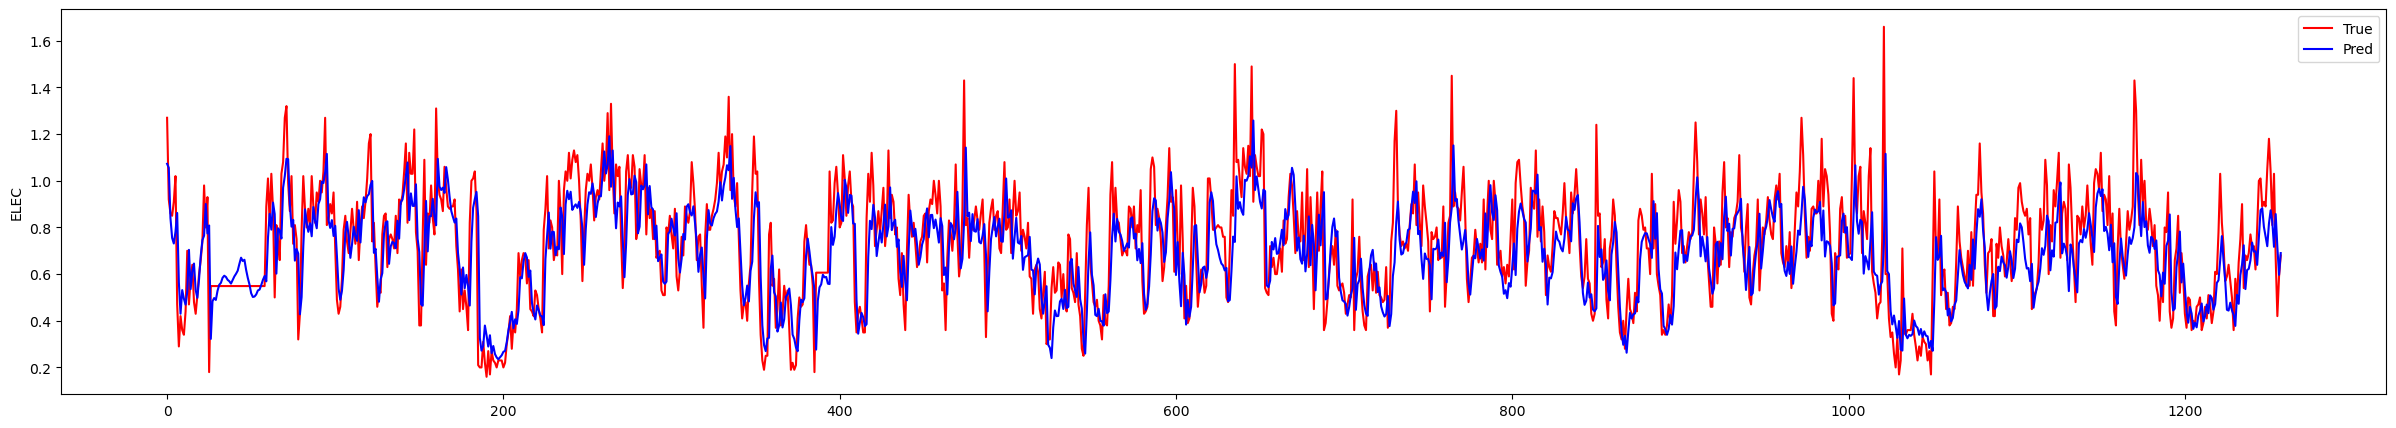

In [29]:
plt.figure(figsize=(30,5))
plt.ylabel('ELEC')
plt.plot(real, color='red', label='True')
plt.plot(pred, color='blue', label='Pred')
plt.legend()
plt.show()